In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import time

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

Using TensorFlow backend.


In [2]:
df = pd.read_csv("data/prices-split-adjusted.csv", index_col=0)
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [46]:
google_stock = df[df['symbol'] == 'GOOG']

In [47]:
google_stock.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,GOOG,312.304948,312.205308,310.955001,313.580158,3927000.0
2010-01-05,GOOG,312.419511,310.830459,309.610028,312.748278,6031900.0
2010-01-06,GOOG,311.761979,302.994813,302.048370,311.761979,7987100.0
2010-01-07,GOOG,303.562685,295.941242,295.218951,303.861575,12876600.0
2010-01-08,GOOG,294.895159,299.886470,293.455551,300.499172,9483900.0


In [48]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
goog_df = google_stock.copy()
goog_df.drop(['symbol'], axis=1, inplace=True)
x = goog_df[['open', 'low', 'high', 'volume']].copy()
y = goog_df['close'].copy()

x[['open', 'low', 'high', 'volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [49]:
train_size = int(len(x) * 0.8)
test_size = len(x) - train_size
train, test = x.iloc[0:train_size, :], x.iloc[train_size:len(x), :]
trainY, testY = y[0:train_size], y[train_size:len(y)]

print('Split data into training set and test set... Number of training samples/ test samples:', len(train), len(test))

Split data into training set and test set... Number of training samples/ test samples: 1409 353


In [50]:
look_back = 7

def create_dataset(X, y, look_back):
    dataX = np.zeros((len(X), look_back, len(X.columns)))
    dataY = np.zeros(len(y))
    X = X.copy()
    y = y.copy()
    for i in range(len(X)-look_back-1):
        a = X.iloc[i:(i+look_back), :]
        dataX[i] = a
        dataY[i] = y[i + look_back]
    return dataX, dataY

trainX, trainY = create_dataset(train, trainY, look_back)
testX, testY = create_dataset(test, testY, look_back)

In [51]:
def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    return model

In [52]:
model = build_model(input_shape=(look_back, 4))

In [53]:
model.fit(trainX, trainY, batch_size=32, epochs=500, verbose=0)

In [54]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [55]:
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([trainY])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([testY])

In [56]:
trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9.20 RMSE
Test Score: 42.97 RMSE


In [57]:
google_stock_prices = google_stock.close.values.astype('float32')
google_stock_prices = google_stock_prices.reshape(len(google_stock_prices), 1)

In [58]:
trainPredictPlot = np.empty_like(google_stock_prices)
trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(google_stock_prices)
testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(google_stock_prices)-1, :] = testPredict
testPredictPlot[(len(google_stock_prices) - testPredict.shape[0]):len(google_stock_prices), :] = testPredict

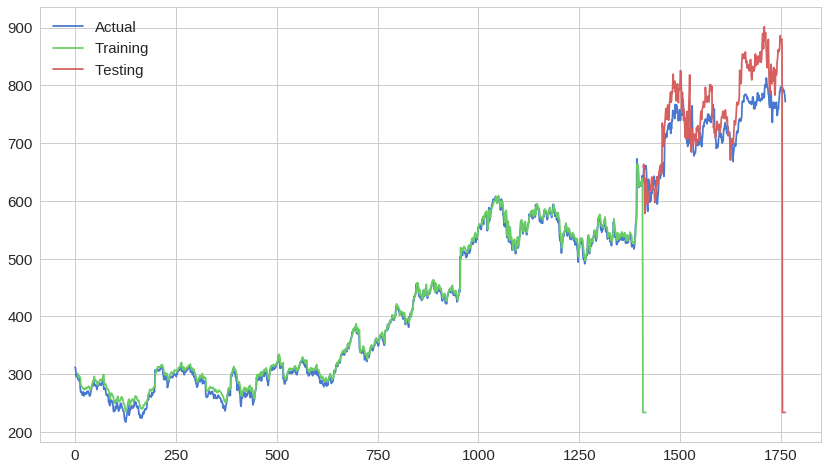

In [59]:
plt.plot(google_stock_prices, label='Actual')
plt.plot(trainPredictPlot, label='Training')
plt.plot(testPredictPlot, label='Testing')
plt.legend(loc='best')
plt.show()